In [1]:
import pandas as pd
import sklearn

In [2]:
pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sqlalchemy as sa

In [4]:
from Bio import SeqIO

In [9]:
from Bio import SeqIO
import pandas as pd
import sqlalchemy as sa

# 1. Database Connection
engine = sa.create_engine('sqlite:///covid_data.db')

# 2. Create Table
with engine.connect() as conn:
    conn.execute(sa.text("""
    CREATE TABLE IF NOT EXISTS variants (
        accession_id VARCHAR PRIMARY KEY,
        sequence TEXT,
        host VARCHAR,
        location VARCHAR,
        collection_date DATE
    );
    """))

# 3. Read FASTA file and load into a DataFrame
records = []
for record in SeqIO.parse("COVID_sequence.fasta.fasta", "fasta"):
    description_parts = record.description.split(" ")
    
    # Extract metadata from the description line
    accession_id = description_parts[0]
    host = 'N/A'
    location = 'N/A'
    collection_date = 'N/A'
    
    # Simple parsing logic based on description format
    for part in description_parts:
        if part.startswith('host='):
            host = part.split('=')[1]
        if part.startswith('location='):
            location = part.split('=')[1]
        if part.startswith('collection_date='):
            collection_date = part.split('=')[1]
            
    records.append({
        'accession_id': accession_id,
        'sequence': str(record.seq),
        'host': host,
        'location': location,
        'collection_date': collection_date
    })

df = pd.DataFrame(records)

# 4. Load DataFrame into SQL Table
df.to_sql('variants', engine, if_exists='replace', index=False)

print("Data loaded successfully into covid_data.db!")

Data loaded successfully into covid_data.db!


In [10]:
import pandas as pd
import sqlalchemy as sa
from Bio import SeqIO

# Connect to your database and load data into a DataFrame
engine = sa.create_engine('sqlite:///covid_data.db')
query = "SELECT * FROM variants"
df = pd.read_sql(query, engine)

# Print the first 5 rows to verify the data
print(df.head())

  accession_id                                           sequence host  \
0   PH327906.1                                        TACAATCCCTC  N/A   
1   PH327857.1  ATGTCAAGCTCTTCCTGGCTCCTTCTCAGCCTTGTTGCTGTAACTG...  N/A   
2   PI050044.1  ATGAAACTTGTCTTCCTCGTCCTGCTGTTCCTCGGGGCCCTCGGAC...  N/A   
3   PH403602.1                               AGGGGCCATCCACAGTCTTC  N/A   
4   PH403601.1                               AGAAGGCTGGGGCTCATTTG  N/A   

  location collection_date  
0      N/A             N/A  
1      N/A             N/A  
2      N/A             N/A  
3      N/A             N/A  
4      N/A             N/A  


In [11]:
import sqlalchemy as sa

# Connect to your database
engine = sa.create_engine('sqlite:///covid_data.db')

# Get the table names from the database
inspector = sa.inspect(engine)
table_names = inspector.get_table_names()

print("Tables in the database:", table_names)

Tables in the database: ['variants']


In [12]:
from Bio import SeqIO
from Bio import Entrez
import pandas as pd
import sqlalchemy as sa

# Apni email ID yahan daalein
Entrez.email = "sadhanaiiita636@gmail.com" 

# Asli reference sequence ko NCBI se fetch karein
print("Fetching reference sequence from NCBI...")
handle = Entrez.efetch(db="nucleotide", id="NC_045512.2", rettype="fasta", retmode="text")
reference_record = SeqIO.read(handle, "fasta")
reference_seq = str(reference_record.seq)

print("Reference sequence fetched successfully.")

# Ab, apne database se data load karein
engine = sa.create_engine('sqlite:///covid_data.db')
df = pd.read_sql("SELECT * FROM variants", engine)

# Mutations dhoondhne ka function
def find_mutations(variant_seq, ref_seq):
    mutations = []
    # Sirf pehle 1000 bases ki tulna karte hain taaki code jaldi chale
    comparison_length = min(len(variant_seq), len(ref_seq), 1000)
    
    for i in range(comparison_length):
        if i < len(variant_seq) and variant_seq[i] != ref_seq[i]:
            mutation = f"{ref_seq[i]}{i+1}{variant_seq[i]}"
            mutations.append(mutation)
    return mutations

# 'mutations' column banayein
df['mutations'] = df['sequence'].apply(lambda x: find_mutations(x, reference_seq))

# Naye DataFrame ko print karen
print("\nDataFrame with mutations:")
print(df.head())

Fetching reference sequence from NCBI...
Reference sequence fetched successfully.

DataFrame with mutations:
  accession_id                                           sequence host  \
0   PH327906.1                                        TACAATCCCTC  N/A   
1   PH327857.1  ATGTCAAGCTCTTCCTGGCTCCTTCTCAGCCTTGTTGCTGTAACTG...  N/A   
2   PI050044.1  ATGAAACTTGTCTTCCTCGTCCTGCTGTTCCTCGGGGCCCTCGGAC...  N/A   
3   PH403602.1                               AGGGGCCATCCACAGTCTTC  N/A   
4   PH403601.1                               AGAAGGCTGGGGCTCATTTG  N/A   

  location collection_date                                          mutations  
0      N/A             N/A          [A1T, T2A, T3C, A6T, G7C, G8C, T9C, T11C]  
1      N/A             N/A  [T3G, A4T, A5C, G7A, T9C, T11C, A12T, A14C, C1...  
2      N/A             N/A  [T3G, G7C, G8T, T10G, A12C, A14T, T18C, C19G, ...  
3      N/A             N/A  [T2G, T3G, A4G, A5G, A6C, G7C, G8A, T10C, T11C...  
4      N/A             N/A  [T2G, T3A, A5G, A6

In [13]:
from collections import Counter

# mutations ke saare lists ko ek flat list mein badlein
all_mutations = [mutation for sublist in df['mutations'] for mutation in sublist]

# Har mutation ko count karein
mutation_counts = Counter(all_mutations)

# Sabse common 10 mutations print karein
print("Top 10 Most Common Mutations:")
for mutation, count in mutation_counts.most_common(10):
    print(f"{mutation}: {count} times")

Top 10 Most Common Mutations:
G7C: 11 times
T9C: 11 times
T11C: 11 times
T3G: 10 times
T2G: 10 times
A14C: 8 times
G8A: 8 times
A5C: 7 times
T13C: 7 times
T18C: 6 times


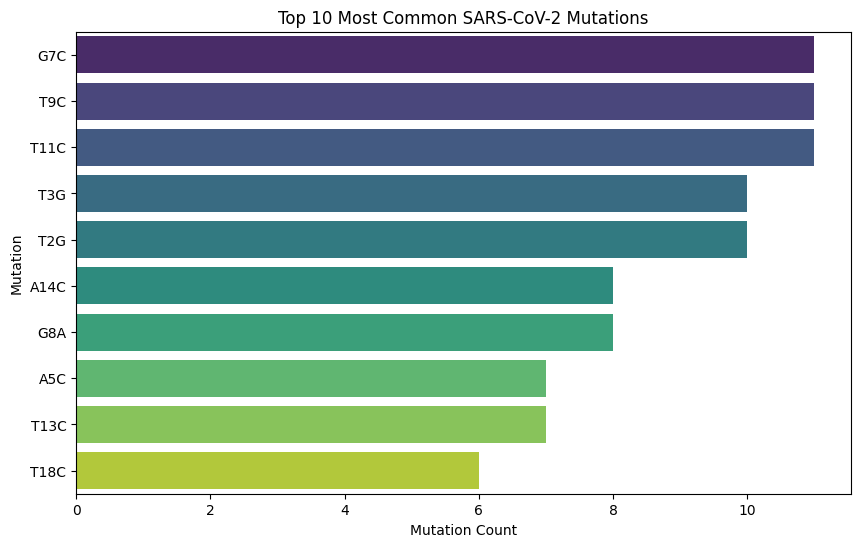

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 mutations ko nikal lein
top_10_mutations = mutation_counts.most_common(10)

mutation_names = [item[0] for item in top_10_mutations]
mutation_values = [item[1] for item in top_10_mutations]

plt.figure(figsize=(10, 6))
sns.barplot(x=mutation_values, y= mutation_names, hue=mutation_names, palette="viridis", legend=False)
plt.title('Top 10 Most Common SARS-CoV-2 Mutations')
plt.xlabel('Mutation Count')
plt.ylabel('Mutation')
plt.show()
